In [1]:
import numpy as np
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from deap import base, creator, tools, algorithms
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import random
import numpy as np
from keras.models import load_model
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from deap import base, creator, tools, algorithms
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import random
import numpy as np
from deap import base, creator, tools, algorithms
from tensorflow import keras
from keras import layers
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'


In [3]:
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')


In [4]:
all_features = np.load('all_features_vgg19.npy')
all_labels = np.load('all_labels_vgg19.npy')



In [5]:
all_features

array([[-1.2288334e-02, -2.8639566e-02, -4.1679051e-02, ...,
        -1.2243470e-02, -3.4375422e-02,  1.6440372e+01],
       [-1.2288334e-02, -2.8639566e-02, -4.1679051e-02, ...,
        -1.2243470e-02, -3.4375422e-02, -5.7346612e-02],
       [-1.2288334e-02, -2.8639566e-02, -4.1679051e-02, ...,
        -1.2243470e-02, -3.4375422e-02, -5.7346612e-02],
       ...,
       [-1.2288334e-02, -2.8639566e-02, -4.1679051e-02, ...,
        -1.2243470e-02, -3.4375422e-02, -5.7346612e-02],
       [-1.2288334e-02, -2.8639566e-02, -4.1679051e-02, ...,
        -1.2243470e-02, -3.4375422e-02, -5.7346612e-02],
       [-1.2288334e-02, -2.8639566e-02, -4.1679051e-02, ...,
        -1.2243470e-02, -3.4375422e-02, -5.7346612e-02]], dtype=float32)

In [6]:
all_labels

array([[0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]])

In [7]:
from sklearn.model_selection import train_test_split
import numpy as np

x_train, x_test, y_train, y_test = train_test_split( all_features, all_labels, test_size=0.2, random_state=42 )

In [8]:
num_classes=4

In [9]:
y_train

array([[0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [10]:
y_test

array([[0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [11]:
def evaluate_model(individual):
    num_layers = int(individual[0])  # Ensure num_layers is an integer
    neurons_per_layer = individual[1]
    dropout_rate = individual[2]

    # Create the model
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=(x_train.shape[1],)))

    for _ in range(num_layers):
        model.add(layers.Dense(neurons_per_layer, activation='relu'))
        model.add(layers.Dropout(dropout_rate))
    
    model.add(layers.Dense(4, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Early stopping callback
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Train the model
    history = model.fit(x_train, y_train, epochs=20, batch_size=64, validation_split=0.2, verbose=0, callbacks=[early_stopping])

    # Evaluate the model
    _, accuracy = model.evaluate(x_test, y_test, verbose=0)
    
    return accuracy,  

In [12]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))  # Maximizing the fitness value
creator.create("Individual", list, fitness=creator.FitnessMax)

# Register functions
toolbox = base.Toolbox()
toolbox.register("num_layers", lambda: random.choice([2,4,8,16]))  # Number of layers (must be integer)
toolbox.register("neurons_per_layer", lambda: random.choice([128, 256, 512, 1024]))  # Number of neurons per layer
toolbox.register("dropout_rate", lambda: random.choice([0.2, 0.4]))  # Dropout rate

toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.num_layers, toolbox.neurons_per_layer, toolbox.dropout_rate), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate_model)
toolbox.register("mate", tools.cxTwoPoint)

# Corrected mutation function using mutPolynomialBounded for continuous values
toolbox.register("mutate", tools.mutPolynomialBounded, low=[1, 32, 0.0], up=[5, 512, 1.0], eta=1.0, indpb=0.2)

toolbox.register("select", tools.selTournament, tournsize=3)


In [13]:
population = toolbox.population(n=10)  # Number of individuals
NGEN = 10  # Number of generations
CXPB, MUTPB = 0.5, 0.2  # Crossover and mutation probabilities

best_accuracy = 0  # To track the best model's accuracy
best_model = None  # Variable to store the best model

for gen in range(NGEN):
    print(f"Generation {gen}")
    offspring = algorithms.varAnd(population, toolbox, cxpb=CXPB, mutpb=MUTPB)

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    # Select the next generation population
    population[:] = toolbox.select(offspring, len(population))

    # Track the best individual in the current generation
    best_ind = tools.selBest(population, 1)[0]
    current_accuracy = best_ind.fitness.values[0]

    if current_accuracy > best_accuracy:
        best_accuracy = current_accuracy
        # Recreate the model from the best individual
        num_layers = int(best_ind[0])
        neurons_per_layer = best_ind[1]
        dropout_rate = best_ind[2]

        best_model = models.Sequential()
        best_model.add(layers.InputLayer(input_shape=(x_train.shape[1],)))
        for _ in range(num_layers):
            best_model.add(layers.Dense(neurons_per_layer, activation='relu'))
            best_model.add(layers.Dropout(dropout_rate))

        best_model.add(layers.Dense(4, activation='softmax'))

        # Compile the model
        best_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



# Print the best individual
print(f"Best individual: {best_ind}")
print(f"Best fitness: {best_ind.fitness.values[0]}")

Generation 0
Generation 1
Generation 2
Generation 3
Generation 4
Generation 5
Generation 6
Generation 7
Generation 8
Generation 9
Best individual: [1.303930709176211, 256, 0.2]
Best fitness: 0.8921348452568054


In [14]:
# Round the parameters dynamically
num_layers = int(round(best_ind[0]))  # Round the number of layers to the nearest integer
neurons_per_layer = int(best_ind[1])  # Neurons per layer remain the same, assuming it's already an integer
dropout_rate = best_ind[2]



# Print the rounded parameters
print(f"Rounded Parameters: Layers = {num_layers}, Neurons per Layer = {neurons_per_layer}, Dropout Rate = {dropout_rate}")

# Build the model dynamically with the rounded parameters
model = models.Sequential()

# Input layer
model.add(layers.InputLayer(input_shape=(x_train.shape[1],)))  # Replace x_train.shape[1] with your input shape

# Add layers based on the number of layers
for _ in range(num_layers):
    model.add(layers.Dense(neurons_per_layer, activation='relu'))
    model.add(layers.Dropout(dropout_rate))

# Output layer (for 4 classes, softmax activation)
model.add(layers.Dense(4, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model to see the architecture
model.summary()

Rounded Parameters: Layers = 1, Neurons per Layer = 256, Dropout Rate = 0.2
Model: "sequential_69"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_244 (Dense)           (None, 256)               6422784   
                                                                 
 dropout_175 (Dropout)       (None, 256)               0         
                                                                 
 dense_245 (Dense)           (None, 4)                 1028      
                                                                 
Total params: 6423812 (24.50 MB)
Trainable params: 6423812 (24.50 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
history = model.fit(x_train, y_train, epochs=50, batch_size=32,validation_data=[x_train, y_train])


Epoch 1/50
167/167 [==============================] - 2s 8ms/step - loss: 5.3764 - accuracy: 0.6980 - val_loss: 1.2097 - val_accuracy: 0.9243
Epoch 2/50
167/167 [==============================] - 1s 8ms/step - loss: 1.2220 - accuracy: 0.9245 - val_loss: 0.1421 - val_accuracy: 0.9841
Epoch 3/50
167/167 [==============================] - 1s 8ms/step - loss: 0.3057 - accuracy: 0.9768 - val_loss: 0.0608 - val_accuracy: 0.9968
Epoch 4/50
167/167 [==============================] - 1s 8ms/step - loss: 0.1276 - accuracy: 0.9871 - val_loss: 0.0261 - val_accuracy: 0.9968
Epoch 5/50
167/167 [==============================] - 1s 8ms/step - loss: 0.0513 - accuracy: 0.9914 - val_loss: 0.0106 - val_accuracy: 0.9989
Epoch 6/50
167/167 [==============================] - 1s 8ms/step - loss: 0.1402 - accuracy: 0.9914 - val_loss: 0.0339 - val_accuracy: 0.9985
Epoch 7/50
167/167 [==============================] - 1s 8ms/step - loss: 0.1566 - accuracy: 0.9903 - val_loss: 0.0506 - val_accuracy: 0.9974
Epoch 

In [16]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)

# Print out the test loss and accuracy
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

42/42 [==============================] - 0s 2ms/step - loss: 27.5772 - accuracy: 0.9161
Test Loss: 27.577150344848633
Test Accuracy: 0.9161048531532288


In [17]:
from sklearn.metrics import classification_report
import numpy as np

# Make predictions on the test data
y_pred = model.predict(x_test)

# If you have one-hot encoded labels, you may need to use argmax to convert them back to class labels
y_pred_classes = np.argmax(y_pred, axis=1)  # Converts the one-hot encoded predictions to class labels
y_test_classes = np.argmax(y_test, axis=1)  # Same for the true labels if they are one-hot encoded

# Generate the classification report
report = classification_report(y_test_classes, y_pred_classes)
print(report)


42/42 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.91      0.85      0.88       197
           1       0.44      0.67      0.53        18
           2       0.93      0.96      0.95       645
           3       0.92      0.90      0.91       475

    accuracy                           0.92      1335
   macro avg       0.80      0.84      0.82      1335
weighted avg       0.92      0.92      0.92      1335



In [18]:
y_pred = model.predict(x_test)

# If you have one-hot encoded labels, you may need to use argmax to convert them back to class labels
y_pred_classes = np.argmax(y_pred, axis=1)  # Converts the one-hot encoded predictions to class labels
y_test_classes = np.argmax(y_test, axis=1)  # Same for the true labels if they are one-hot encoded

# Generate the classification report
report = classification_report(y_test_classes, y_pred_classes)
print(report)

42/42 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.91      0.85      0.88       197
           1       0.44      0.67      0.53        18
           2       0.93      0.96      0.95       645
           3       0.92      0.90      0.91       475

    accuracy                           0.92      1335
   macro avg       0.80      0.84      0.82      1335
weighted avg       0.92      0.92      0.92      1335



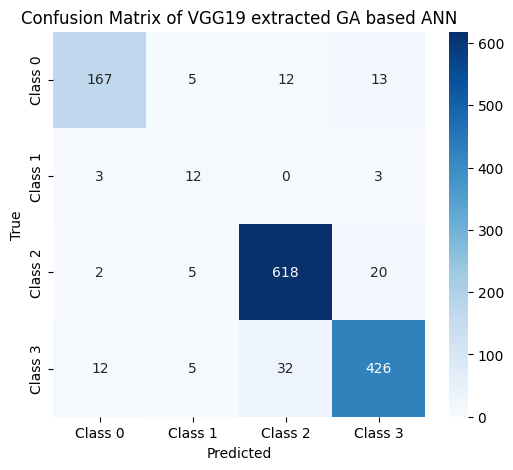

In [19]:
cm = confusion_matrix(y_test_classes, y_pred_classes)

# Plot the confusion matrix using a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1", "Class 2", "Class 3"], yticklabels=["Class 0", "Class 1", "Class 2", "Class 3"])
plt.title("Confusion Matrix of VGG19 extracted GA based ANN")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

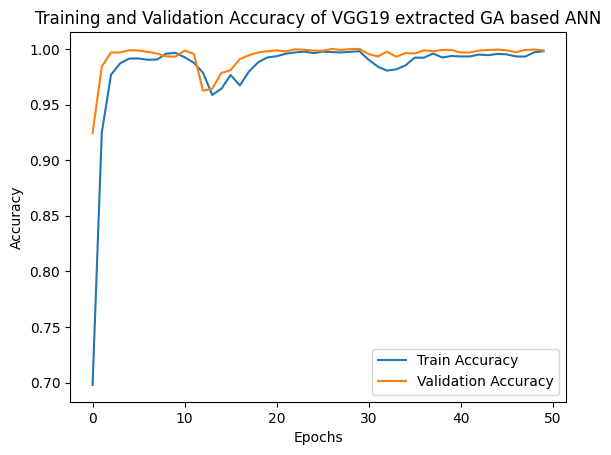

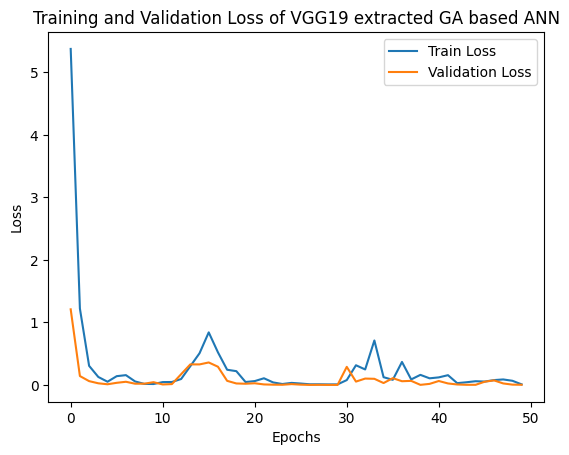

In [23]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy of VGG19 extracted GA based ANN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss of VGG19 extracted GA based ANN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [24]:
model.save("best_vgg19.h5")